# Практикум №1 #
## Регулярные выражения ##
## Вариант №4 ##
### Михаил Цион 797 ###

$ 
\\
\quad\textbf{Задача}\\
Даны\space\alpha,\spaceбуква\space{x}\spaceи\spaceнатуральное\spaceчисло\space{k}.\spaceВывести,\spaceесть\spaceли\spaceв\spaceязыке\space{L}\spaceслова,\spaceсодержащие\spaceподслово\space{x^{k}}.
$

$
Функция\space\textbf{parse_regexp}\spaceдля\spaceвалидации\spaceвходящего\spaceрегулярного\spaceвыражения.
$

In [23]:
def parse_regexp(regexp_notation):
    notation_list = []
    for symbol in regexp_notation:
        if symbol in [' ', '+', '*', '.', '1']:
            if symbol != ' ':
                notation_list.append(symbol)    
        elif symbol in ['a', 'b', 'c']:
            notation_list.append(symbol)
        elif symbol in ['∗', '', '', '']:
            notation_list.append({
                '∗':'*',
                '𝑎':'a',
                '𝑏':'b',
                '𝑐':'c'
            }[symbol])
        else:
            return "ERROR"
    return notation_list

$
Класс\space\textbf{State}\spaceхранит\spaceданные\spaceоб\spaceиндексе\spaceсостояния\spaceв\space{vertices\space table}\spaceи\spaceиндексы\spaceдостижимых\spaceсостояний\spaceпо\spaceконкретному\spaceпереходу.\\
В\space {vertices\space table}\spaceхраним\spaceсписок\spaceвсех\spaceсостояний\space(да,\spaceон\spaceбольше\spaceотносится\spaceк\spaceклассу\space\textbf{Automaton},\spaceно\spaceхудожник\spaceвидит\spaceтак,\spaceс\spaceточки\\зрения\spaceпрограммной\spaceархитектуры\spaceэто\spaceнехорошо,\spaceя\spaceтак\spaceбольше\spaceне\spaceбуду).\spaceСписок\spaceсамоочищается\spaceпри\spaceсоздании\spaceнового\spaceавтомата.
$

In [24]:
class State:

    states_table = []
    
    def __init__(self, is_terminal=False):
        self.is_terminal = is_terminal
        self.next_states = []
        self.state_idx = len(State.states_table)
        State.states_table.append(self)

    def add_transition(self, transition, state_num):
        self.next_states.append((transition, state_num))

$
Класс\space\textbf{Automaton}\spaceописывающий\spaceавтомат,\spaceхранит\spaceномер\spaceначального\spaceи\spaceтерминального\spaceсостояний,\spaceкоторые\spaceхранятся\spaceв\space{states\space table}.
$

In [25]:
class Automaton:

    def __init__(self, transition):
        entry_state = State()
        self.entry_state_num = entry_state.state_idx
        terminal_state = State(True)
        self.terminal_state_num = terminal_state.state_idx
        entry_state.add_transition(transition, self.terminal_state_num)

    def get_entry(self):
        return self.entry_state_num

    def get_terminal(self):
        return self.terminal_state_num

    @classmethod
    def concat(cls, lhs, rhs):
        """
            Соединяем эпсилон переходом терминальное в lhs-автомате с 
            начальным в rhs-автомате.
        """
        lhs_state = State.states_table[lhs.get_terminal()]
        lhs_state.is_terminal = False
        rhs_state = State.states_table[rhs.get_entry()]
        lhs_state.add_transition('1', rhs.get_entry())
        lhs.terminal_state_num = rhs.terminal_state_num
        return lhs

    @classmethod
    def merge(cls, lhs, rhs):
        """
            Создаем два дополнительных состояния, которые станут начальным
            и терминальным в новом автомате. Соединяем эпсилон-переходами
            начальное в lhs-автомате и начальное в rhs-автомате c новым
            начальным состоянием. Аналогично с терминальными.
            На выходе получаем.
        """
        lhs_entry_num = lhs.get_entry()
        rhs_entry_num = rhs.get_entry()
        
        lhs_terminal_num = lhs.get_terminal()
        rhs_terminal_num = rhs.get_terminal()
        
        lhs_entry = State.states_table[lhs_entry_num]
        rhs_entry = State.states_table[rhs_entry_num]
        
        lhs_terminal = State.states_table[lhs_terminal_num]
        rhs_terminal = State.states_table[rhs_terminal_num]

        new_entry = State()
        new_terminal = State()
        
        new_entry.add_transition('1', lhs_entry_num)
        new_entry.add_transition('1', rhs_entry_num)
        lhs_terminal.add_transition('1', new_terminal.state_idx)
        rhs_terminal.add_transition('1', new_terminal.state_idx)
        
        lhs.entry_state_num = new_entry.state_idx
        lhs.terminal_state_num = new_terminal.state_idx
        
        return lhs

    def starify(self):
        """
            Добавляем эпсилон-переходы от начального состояния в терминальное,
            так и от терминального к начальному.
        """
        entry_num, terminal_num = self.get_entry(), self.get_terminal()
        if ('1', terminal_num) not in State.states_table[entry_num].next_states:
            State.states_table[entry_num].add_transition('1', terminal_num)
        if ('1', entry_num) not in State.states_table[terminal_num].next_states:
            State.states_table[terminal_num].add_transition('1', entry_num)
        return self

$
Функция\space\ \textbf{build_automaton}\spaceпостроения\spaceавтомата\spaceпо\spaceрегулярному\spaceвыражению\spaceв\spaceобратной\spaceпольской\spaceзаписи
$

In [26]:
from collections import deque

def build_automaton(regexp_notation):
    State.states_table = []
    response = parse_regexp(regexp_notation)
    if response == "ERROR":
        return "ERROR"
    stack = deque()
    for symbol in response:
        if symbol in ['a', 'b', 'c', '1']:
            stack.append(Automaton(symbol))
        else:
            if symbol == '.':
                if len(stack) <= 1:
                    return "ERROR"
                rhs = stack.pop()
                lhs = stack.pop()
                stack.append(Automaton.concat(lhs, rhs))
            elif symbol == '+':
                if len(stack) <= 1:
                    return "ERROR"
                rhs = stack.pop()
                lhs = stack.pop()
                stack.append(Automaton.merge(lhs, rhs))
            elif symbol == '*':
                stack.append(stack.pop().starify())
    if len(stack) != 1:
        return "ERROR"
    return stack[0]

### Для изображения построенного автомата используется библиотека graphviz ###

In [27]:
try:
    import graphviz
except:
    import sys
    !{sys.executable} -m pip3 install graphviz
    import graphviz

Также для установки полного пакета для $graphviz$ следует посетить сайт:
https://graphviz.gitlab.io/_pages/Download/Download_source.html .
Скачать и следовать инструкциям по установки.


### Отрисовка автомата ###

In [28]:
from graphviz import Digraph


def show_automaton(automaton):
    if automaton == "ERROR":
        print("ERROR")
        return
    
    graphics = Digraph(comment='Finite automaton')
    graphics.attr(rankdir='LR', size='8,5')
    graphics.attr('node', shape='doublecircle')
    graphics.node("EXIT\nSTATE")
    graphics.node("ENTRY\nSTATE")    
    graphics.attr('node', shape='circle')
    
    def cnvrt(state_idx):
        if state_idx == automaton.get_entry():
            return "ENTRY\nSTATE"
        elif state_idx == automaton.get_terminal():
            return "EXIT\nSTATE"
        else:
            return str(state_idx)
    
    marked = set()
    
    def make_traversal(state):
        nonlocal marked
        if state in marked:
           return 
        marked.add(state)
        for (transition, next_state) in State.states_table[state].next_states:
            graphics.edge(cnvrt(state), cnvrt(next_state), label=transition)
            make_traversal(next_state)

    make_traversal(automaton.get_entry())
    
    return graphics

### Функция проверки на наличие подслова вида x^k ###
$
Выполняем\spaceпоиск\spaceв\spaceглубину\spaceс\spaceкаждой\spaceвершины,\spaceпытаясь\spaceпроходить\spaceтолько\spaceпо\space{x-}\spaceили\spaceпо\space{эпсилон-переходам},\spaceт.е.\spaceпытаемся\space\\максимизировать\spaceподпути\spaceпроходящие\spaceтолько\spaceпо\spaceподходящим\spaceсимволам.
$

In [29]:
def check_traversal(automaton, symbol, k):
    used_transitions = set()
    reached = False
    def dfs(state, passed):
        nonlocal used_transitions, reached
        if passed == k or reached:
            reached = True
            return True
        for (transition, next_state) in State.states_table[state].next_states:
            if transition == symbol:
                dfs(next_state, passed + 1)
            elif transition == '1' and state != next_state:
                # проверка на прохождение по циклам состоящих только из эпсилон переходов
                if (state, next_state, passed) not in used_transitions:
                    used_transitions.add((state, next_state, passed))
                    dfs(next_state, passed)
                    used_transitions.remove((state, next_state, passed))
    # запуск обхода с каждой вершины (состояния)
    for state_idx in range(len(State.states_table)):
        visited = set()
        if dfs(state_idx, 0):
            return "YES"
    
    return "NO"
        

### Тесты от лектора ###


$
1)\space ab+c.aba.∗.bac.+.+∗\space a \space 4 \\
\quad Ответ:\space NO \\
2)\space acb..bab.c.∗.ab.ba.+.+∗a.\space b \space 2 \\
\quad Ответ:\space YES
$

$ Вспомогательная\spaceфункция\spaceдля\spaceтестирования $

In [30]:
def make_test(regexp_notation, symbol, k):
    automaton = build_automaton(regexp_notation)
    print(check_traversal(automaton, symbol, k))
    return show_automaton(automaton)

### Тест 1 ###

NO


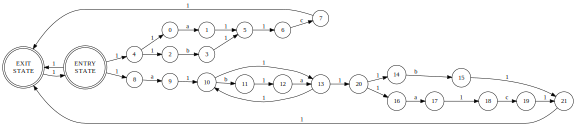

In [31]:
regexp_notation = "ab+c.aba.∗.bac.+.+∗"
symbol = "a"
k = 4

make_test(regexp_notation, symbol, k)

### Тест 2 ###

YES


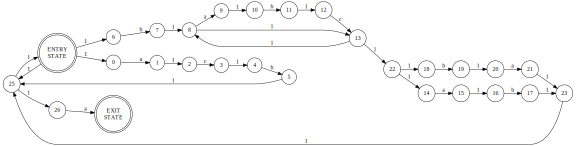

In [32]:
regexp_notation = "acb..bab.c.∗.ab.ba.+.+∗a."
symbol = "b"
k = 2

make_test(regexp_notation, symbol, k)

### Попробуйте сами ###

acb..bab.c.∗.ab.ba.+.+∗a.***
c
3
NO


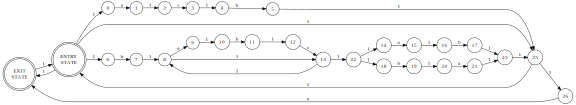

In [33]:
regexp_notation = input()
symbol = input()
k = int(input())

make_test(regexp_notation, symbol, k)